## DCGAN で PyTorch実装を学ぶ
- Reference
  - https://github.com/eriklindernoren/PyTorch-GAN
  - https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/dcgan/dcgan.py

In [1]:
import os
import datetime
import numpy as np
import pandas as pd

In [2]:
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

In [4]:
import torch.nn as nn
#import torch.nn.functional as F
import torch

In [5]:
#torch.__version__

In [6]:
DATA_DIR_PATH = '/content/drive/My Drive/project/ML/pytorch-gan/data'

OUTPUT_DIR_PATH = os.path.join(DATA_DIR_PATH, '03_out')

In [7]:
os.makedirs(os.path.join(OUTPUT_DIR_PATH, 'images'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR_PATH, 'saved_models'), exist_ok=True)

In [8]:
cuda = True if torch.cuda.is_available() else False
print(cuda)

True


In [34]:
latent_dim = 100
img_size = 32
channels = 1

In [35]:
# Configure data loader
MNIST_DATA_DIR_PATH = os.path.join(DATA_DIR_PATH, 'mnist')

batch_size = 64

os.makedirs(MNIST_DATA_DIR_PATH, exist_ok=True)

dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        MNIST_DATA_DIR_PATH,
        train=True,
        download=True,
        transform=transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ]),
    ),
    batch_size=batch_size,
    shuffle=True,
)

In [36]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [37]:
class Generator(nn.Module):
    def __init__(self, img_size, latent_dim, channels):
        super(Generator, self).__init__()

        self.img_size = img_size
        self.latent_dim = latent_dim
        self.channels = channels

        self.init_size = self.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(self.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, self.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [38]:
class Discriminator(nn.Module):
    def __init__(self, img_size, channels):
        super(Discriminator, self).__init__()

        self.img_size = img_size
        self.channels = channels

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [
                     nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.Dropout2d(0.25)
            ]

            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))

            return block

        self.model = nn.Sequential(
            *discriminator_block(self.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = self.img_size // 2 ** 4
        self.adv_layer = nn.Sequential(
            nn.Linear(128 * ds_size ** 2, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [39]:
class DCGAN:
    def __init__(self, data_loader, img_size, latent_dim, channels):
        self.history = pd.DataFrame({}, columns=[
            'epoch', 'batche_i', 'd_loss', 'g_loss', 'elapsed_time'])

        self.data_loader = data_loader

        self.img_save_dir = os.path.join(OUTPUT_DIR_PATH, 'images')
        self.model_save_dir = os.path.join(OUTPUT_DIR_PATH, 'saved_models')
        self.generator_name = 'generator_model'

        self.train_cnt = 0

        self.latent_dim = latent_dim
        self.img_size = img_size
        self.channels = channels

        self.adversarial_loss = torch.nn.BCELoss()

        self.generator = Generator(self.img_size, self.latent_dim, self.channels)
        self.discriminator = Discriminator(self.img_size, self.channels)

        if cuda:
            self.generator.cuda()
            self.discriminator.cuda()
            self.adversarial_loss.cuda()

        self.generator.apply(weights_init_normal)
        self.discriminator.apply(weights_init_normal)

        self.lr = 0.0002
        self.b1 = 0.5
        self.b2 = 0.999

        # Optimizers
        self.optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.b1, self.b2))
        self.optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.b1, self.b2))

    def train(self, n_epochs, sample_interval=-1):
        self.train_cnt += 1

        Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

        print(datetime.datetime.now().isoformat(), 'Start', self.train_cnt)

        start_time = datetime.datetime.now()

        step_cnt = 1

        for epoch in range(1, n_epochs+1):

            for i, (imgs, _) in enumerate(self.data_loader, 1):
                # Adversarial ground truths
                valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
                fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

                # Configure input
                real_imgs = Variable(imgs.type(Tensor))

                # Train Generator
                self.optimizer_G.zero_grad()

                # Sample noise as generator input
                z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], self.latent_dim))))

                # Generate a batch of images
                gen_imgs = self.generator(z)

                # Loss measures generator's ability to fool the discriminator
                g_loss = self.adversarial_loss(self.discriminator(gen_imgs), valid)

                g_loss.backward()
                self.optimizer_G.step()

                # Train Discriminator
                self.optimizer_D.zero_grad()

                # Measure discriminator's ability to classify real from generated samples
                real_loss = self.adversarial_loss(self.discriminator(real_imgs), valid)
                fake_loss = self.adversarial_loss(self.discriminator(gen_imgs.detach()), fake)
                d_loss = (real_loss + fake_loss) / 2

                d_loss.backward()
                self.optimizer_D.step()

                batches_done = epoch * len(self.data_loader) + i
                elapsed_time = datetime.datetime.now() - start_time

                self.history = self.history.append({
                    'epoch': epoch,
                    'batch_i': i,
                    'd_loss': d_loss.item(),
                    'g_loss': g_loss.item(),
                    'elapsed_time': elapsed_time
                }, ignore_index=True)

                if sample_interval > 0 and step_cnt % sample_interval == 0:
                    print(
                        "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                        % (epoch, n_epochs, i, len(self.data_loader), d_loss.item(), g_loss.item())
                    )
                    self.sample_image(epoch, i, gen_imgs)

                step_cnt += 1

        print(datetime.datetime.now().isoformat(), 'End')

    def sample_image(self, epoch, batch_i, gen_imgs):
        file_name = os.path.join(self.img_save_dir, '{}_{}_{}.png'.format(self.train_cnt, epoch, batch_i))
        save_image(gen_imgs.data[:25], file_name, nrow=5, normalize=True)

    def plot_hisotry(self, columns=[]):
        if len(columns) == 0:
            columns = ['d_loss', 'g_loss']
        self.history[columns].plot()

    def save_models(self, file_suffix=None):
        self.save_state_dict(self.generator, self.generator_name, file_suffix)

    def save_state_dict(self, model, model_name, file_suffix=None):
        file_path = os.path.join(self.model_save_dir, self._create_model_file_name(model_name, file_suffix))
        torch.save(model.state_dict(), file_path)
        print('Model saved.', model_name)

    def _create_model_file_name(self, model_name, suffix=None):
        processor = 'gpu' if cuda else 'cpu'

        if suffix:
            return '{}_{}_{}.pth'.format(model_name, processor, suffix)
        else:
            return '{}_{}.pth'.format(model_name, processor)

2020-09-06T22:14:08.118678 Start 1
[Epoch 1/1] [Batch 10/938] [D loss: 0.692631] [G loss: 0.698260]
[Epoch 1/1] [Batch 20/938] [D loss: 0.690516] [G loss: 0.690971]
[Epoch 1/1] [Batch 30/938] [D loss: 0.692105] [G loss: 0.688937]
[Epoch 1/1] [Batch 40/938] [D loss: 0.678473] [G loss: 0.712588]
[Epoch 1/1] [Batch 50/938] [D loss: 0.667179] [G loss: 0.654559]
[Epoch 1/1] [Batch 60/938] [D loss: 0.685418] [G loss: 0.615138]
[Epoch 1/1] [Batch 70/938] [D loss: 0.689941] [G loss: 0.697096]
[Epoch 1/1] [Batch 80/938] [D loss: 0.693768] [G loss: 0.666201]
[Epoch 1/1] [Batch 90/938] [D loss: 0.690055] [G loss: 0.742792]
[Epoch 1/1] [Batch 100/938] [D loss: 0.692094] [G loss: 0.675557]
[Epoch 1/1] [Batch 110/938] [D loss: 0.701715] [G loss: 0.664467]
[Epoch 1/1] [Batch 120/938] [D loss: 0.694447] [G loss: 0.743296]
[Epoch 1/1] [Batch 130/938] [D loss: 0.702888] [G loss: 0.706093]
[Epoch 1/1] [Batch 140/938] [D loss: 0.692642] [G loss: 0.661787]
[Epoch 1/1] [Batch 150/938] [D loss: 0.696145] [G 

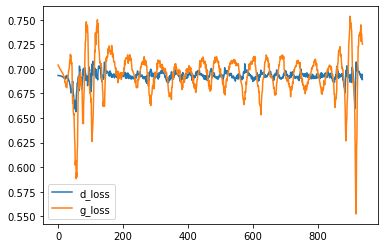

In [40]:
n_epochs = 1
sample_interval = 10

dcgan = DCGAN(dataloader, img_size, latent_dim, channels)
dcgan.train(n_epochs, sample_interval)

dcgan.plot_hisotry()

In [41]:
dcgan.save_models()

Model saved. generator_model
